<a href="https://colab.research.google.com/github/GabrielRocha97/GabrielRocha97.github.io/blob/main/case_shen_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

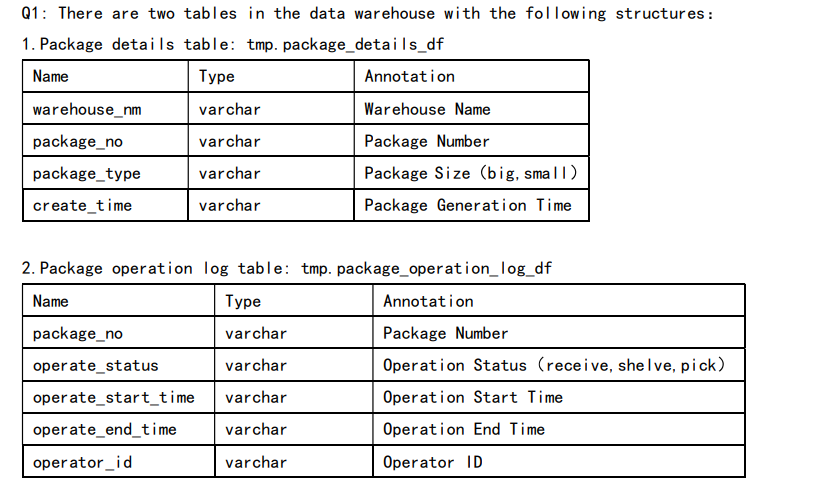


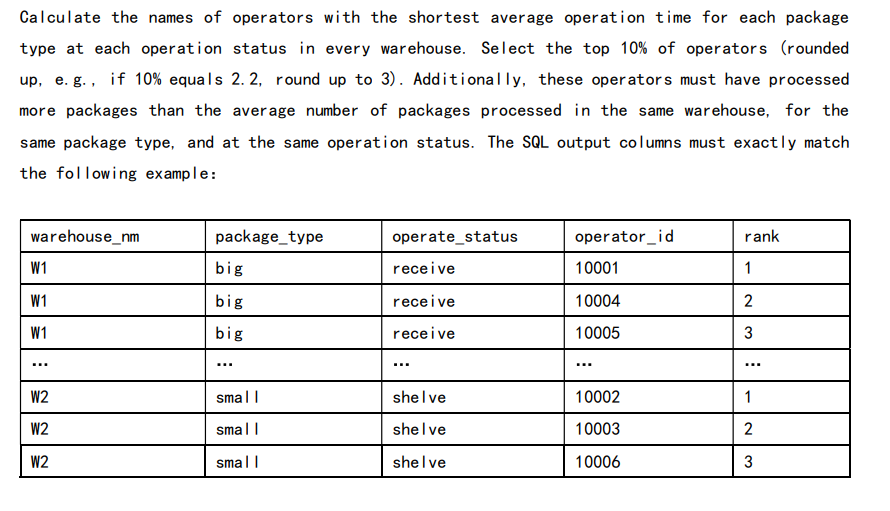

## Problem Summary ##
#### Q1 ####

Within the tmp.package_detail table, we need to follow this combination:

*   warehouse_nm
*   package_type
*   operate_status

And we need to consider the following items:

1.   Calculate the average operation time per operator
2.   Calculate the number of packages each operator processed
3.   Keep only operators above the average number of packages
4.   Sort by the lowest average time
5.   Select the top 10% (always rounding up [example: 2 x 2 = 3])

This query evaluates operator performance within each warehouse, package type, and operation status. It calculates the average operation time and total number of processed packages per operator, filters out operators who processed fewer packages than the group average, ranks the remaining operators by shortest average operation time, and selects the top 10% (rounded up) of the fastest operators in each group.

In [ ]:
```sql
WITH BASE_DATA AS (
    SELECT
        P.warehouse_nm
        ,P.package_type
        ,O.operate_status
        ,O.operator_id
        ,O.package_no
        ,(unix_timestamp(o.operate_end_time) - unix_timestamp(o.operate_start_time)) AS operate_duration
    FROM tmp.package_details_df p
    LEFT JOIN tmp.package_operation_log_df o
        ON p.package_no = o.package_no
)
,OPERATOR_METRICS AS (
    SELECT
        warehouse_nm
        ,package_type
        ,operate_status
        ,operator_id
        ,COUNT(DISTINCT package_no) AS package_cnt
        ,AVG(operate_duration) AS avg_operate_time
    FROM BASE_DATA
    GROUP BY
        ,warehouse_nm
        ,package_type
        ,operate_status
        operator_id
)
,GROUP_METRICS AS (
    SELECT
        warehouse_nm
       ,package_type
       ,operate_status
       ,AVG(package_cnt) AS avg_package_cnt
       ,COUNT(*) AS total_operators
    FROM OPERATOR_METRICS
    GROUP BY
        ,warehouse_nm
        ,package_type
        operate_status
)
,FILTERED_OPERATORS AS (
    SELECT
        o.*
        ,g.total_operators
        ,CEIL(g.total_operators * 0.1) AS top_n
    FROM OPERATOR_METRICS o
    LEFT JOIN GROUP_METIRCS g
        ON o.warehouse_nm = g.warehouse_nm
            AND o.package_type = g.package_type
                AND o.operate_status = g.operate_status
    WHERE o.package_cnt > g.avg_package_cnt
)
,RANKED_OPERATORS AS (
    SELECT
        warehouse_nm
        ,package_type
        ,operate_status
        ,operator_id
        ,ROW_NUMBER() OVER (
            PARTITION BY warehouse_nm, package_type, operate_status
            ORDER BY avg_operate_time ASC
        ) AS rank
        ,top_n
    FROM filtered_operators
)

SELECT
    warehouse_nm,
    package_type,
    operate_status,
    operator_id,
    rank
FROM RANKED_OPERATORS
WHERE rank <= top_n
ORDER BY warehouse_nm, package_type, operate_status, rank;
```

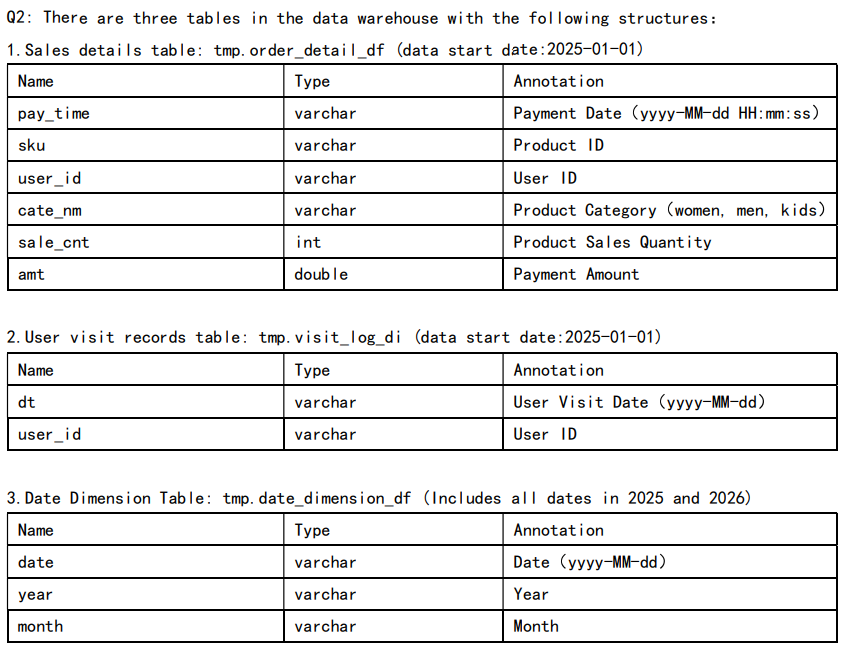

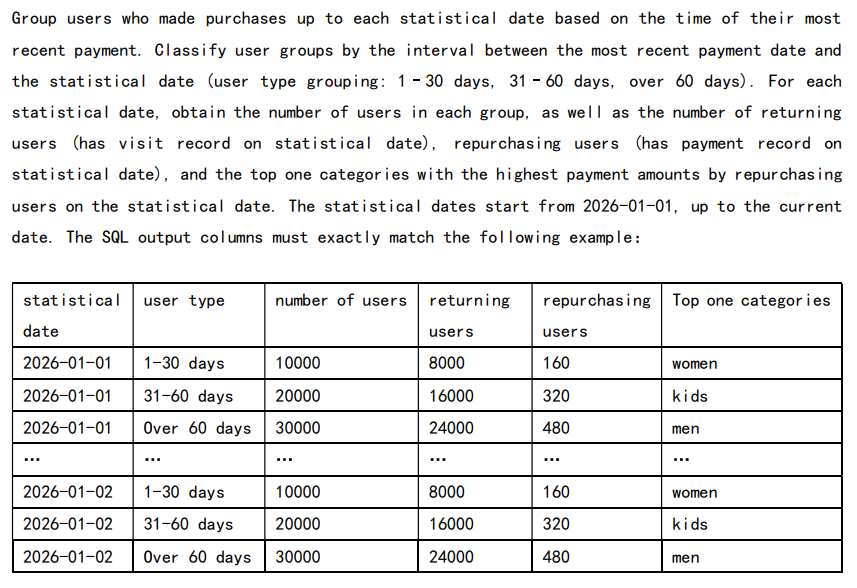


## Problem Summary ##
#### Q2 ####

For each statistical date from:

*   2026-01-01 and current_date

We Need:

1.   Classify users based on the difference between:
* Their most recent payment date
* The statistical date
* User Groups:
1-30 days;31-60 days;over 60 days
2.   For each statistical date and user group, compute:
* Number of users
* Returning users (visited that day)
* Repurchasing users (paid that day)
* Top 1 category by payment amount from repurchasing users

This query performs a daily user segmentation based on purchase recency starting from January 1, 2026. For each statistical date, it identifies each user’s most recent payment up to that day and classifies users into three recency groups: 1–30 days, 31–60 days, and over 60 days.

* For each date and user group, the query calculates:

* The total number of users

* The number of returning users (those who visited on that day)

* The number of repurchasing users (those who made a payment on that day)

* The top revenue-generating product category among repurchasing users

Overall, the query builds a daily behavioral analysis combining recency segmentation, engagement (visits), repurchase activity, and revenue concentration by category.

In [ ]:
```sql

WITH STATISTICAL_DATE AS (
    SELECT date AS statistical_date
    FROM TMP.DATE_DIMENSION_DF
    WHERE date >= '2026-01-01'
      AND date <= CURRENT_DATE
)
,USER_LAST_PAYMENT AS (
    SELECT
        s.statistical_date
        ,o.user_id
        ,MAX(to_date(o.pay_time)) AS last_pay_date
    FROM STATISTICAL_DATE s
    LEFT JOIN TMP.ORDER_DETAIL_DF o
        ON to_date(o.pay_time) <= s.statistical_date
    GROUP BY
        s.statistical_date
        ,o.user_id
)
,USER_GROUPED AS (
    SELECT
        statistical_date
        ,user_id
        ,CASE
            WHEN datediff(statistical_date, last_pay_date) BETWEEN 0 AND 30 THEN '1-30 days'
            WHEN datediff(statistical_date, last_pay_date) BETWEEN 31 AND 60 THEN '31-60 days'
            ELSE 'Over 60 days'
        END AS user_type
    FROM USER_LAST_PAYMENT
)
,RETURNING_USERS AS (
    SELECT
        s.date AS statistical_date
        ,v.user_id
    FROM TMP.DATE_DIMENSION_DF s
    LEFT JOIN TMP.VISIT_LOG_DI v
        ON s.date = v.dt
    WHERE s.date >= '2026-01-01'
      AND s.date <= CURRENT_DATE
)
,REPURCHASING_USERS AS (
    SELECT
        to_date(pay_time) AS statistical_date
        ,user_id
        ,cate_nm
        ,SUM(amt) AS total_amt
    FROM TMP.ORDER_DETAIL_DF
    GROUP BY
        to_date(pay_time)
        ,user_id
        ,cate_nm
)
,TOP_CATEGORY AS (
    SELECT
        statistical_date
        ,cate_nm
    FROM (
        SELECT
            statistical_date
          , cate_nm
          , SUM(total_amt) AS cate_amt
          ,ROW_NUMBER() OVER (
                PARTITION BY statistical_date
                ORDER BY SUM(total_amt) DESC
            ) AS rn
        FROM REPURCHASING_USERS
        GROUP BY statistical_date, cate_nm
    ) t
    WHERE rn = 1
)

SELECT
    u.statistical_date
    ,u.user_type
    ,COUNT(DISTINCT u.user_id) AS number_of_users
    ,COUNT(DISTINCT r.user_id) AS returning_users
    ,COUNT(DISTINCT rp.user_id) AS repurchasing_users
    ,t.cate_nm AS `Top one categories`
FROM USER_GROUPED u
LEFT JOIN RETURNING_USERS r
    ON u.statistical_date = r.statistical_date
    AND u.user_id = r.user_id
LEFT JOIN repurchasing_users rp
    ON u.statistical_date = rp.statistical_date
    AND u.user_id = rp.user_id
LEFT JOIN top_category t
    ON u.statistical_date = t.statistical_date
GROUP BY
    u.statistical_date
    ,u.user_type
    ,t.cate_nm
ORDER BY
    ,u.statistical_date
    u.user_type;
```